# Steam Gaming Insights Report
## Objectives:
- Deep dive on steam gaming data to derive actionable business insights 

## Structure:
- Data Preparation (feature engineering)
- Basic User Statistics
- Market Analysis
- Game and User Analysis (user profiling and KMeans clustering) 
- Executive Summary

## Data Preparation

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
%matplotlib inline 

In [90]:
from sklearn.preprocessing import LabelEncoder,StandardScaler
from scipy.stats import skew,norm
from scipy import stats
from sklearn.cluster import KMeans
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

In [3]:
path=os.path.join(os.getcwd(),'../../Github/test/steam_gaming_small/')
files = os.listdir(os.path.join(os.getcwd(),'../../Github/test/steam_gaming_small'))

In [4]:

### Load all the files
groups = pd.read_csv(path + 'Groups.csv')
genres = pd.read_csv(path + 'Games_Genres.csv')
developers = pd.read_csv(path + 'Games_Developers.csv')
app_id= pd.read_csv(path + 'App_ID_Info.csv')
publisher = pd.read_csv(path + 'Games_Publishers.csv')
friends =pd.read_csv(path + 'Friends.csv')
achievement = pd.read_csv(path + 'Achievement_Percentages.csv')
player_summaries= pd.read_csv(path + 'Player_Summaries.csv')
game1= pd.read_csv(path + 'Games_1.csv')
game2= pd.read_csv(path + 'Games_2.csv')

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:
### Set Index 
groups.set_index('steamid',inplace=True)
genres.set_index('appid',inplace=True)
developers.set_index('appid',inplace=True)
app_id.set_index('appid',inplace=True)
publisher.set_index('appid',inplace=True)
friends.set_index('steamid_a',inplace=True)
achievement.set_index('appid',inplace=True)
player_summaries.set_index('steamid',inplace=True)



### Merge Game 1 and Game 2 
games = game1.merge(game2,left_on=['steamid','appid'],right_on=['steamid','appid'],how='left').rename(columns={
    'playtime_2weeks_x':'game1_playtime_2weeks','playtime_forever_x':'game1_playtime_forever',
    'dateretrieved_x':'game1_dateretrieved','playtime_2weeks_y':'game2_playtime_2weeks',
    'playtime_forever_y':'game2_playtime_forever','dateretrieved_y':'game2_dateretrieved'
    
    
})

In [6]:
### Aggregate and merge tables to create master df which contains all relevant attributes 
achievement.reset_index(inplace=True)
achievement= achievement.groupby(['appid']).mean()[['Percentage']]

friends = friends.groupby('steamid_a').count()
friends = friends.drop(['friend_since','dateretrieved'],axis=1)
friends.rename(columns={'steamid_b':'n_friends'},inplace=True)


games_merge_steamid=games.merge(friends,left_on='steamid',right_on='steamid_a',how='left').groupby(['appid','steamid']).mean()[['game1_playtime_2weeks','game1_playtime_forever','game2_playtime_2weeks','game2_playtime_forever','n_friends']]
games_merge_steamid.reset_index(inplace=True)
games_merge_steamid=games_merge_steamid.merge(player_summaries[['communityvisibilitystate','lastlogoff']],left_on='steamid',right_on='steamid',how='left')

app_id_merge =app_id.merge(achievement['Percentage'],left_index=True,right_index=True,how='left').merge(publisher,left_index=True,right_index=True,how='left').merge(developers,left_index=True,right_index=True,how='left').merge(genres,left_index=True,right_index=True,how='left')
df = app_id_merge.merge(games_merge_steamid,left_on='appid',right_on='appid',how='left')

### Feature Engineering

In [8]:
## Missing values
total = df.isnull().sum().sort_values(ascending=False)
percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
missing_values= pd.concat([total,percent],axis=1,keys=['total','percent'])

### Drop columns with missing values % > .9
df = df.drop(missing_values[missing_values.percent>0.9].index,1)

###Fillna
df.loc[:,'Developer']=df.loc[:,'Developer'].fillna('None')
df.loc[:,'Genre']=df.loc[:,'Genre'].fillna('None')
df.loc[:,'Publisher']=df.loc[:,'Publisher'].fillna('None')
df.loc[:,'steamid']=df.loc[:,'steamid'].fillna(0)
df.loc[:,'game2_playtime_forever']=df.loc[:,'game2_playtime_forever'].fillna(df['game2_playtime_forever'].median())
df.loc[:,'communityvisibilitystate']=df.loc[:,'communityvisibilitystate'].fillna('0')
df.loc[:,'lastlogoff']=df.loc[:,'lastlogoff'].fillna(0)
df.loc[:,'n_friends']=df.loc[:,'n_friends'].fillna(0)
df.loc[:,'game1_playtime_forever']=df.loc[:,'game1_playtime_forever'].fillna(df['game1_playtime_forever'].median())
df.loc[:,'Percentage']=df.loc[:,'Percentage'].fillna(df.Percentage.median())

## Convert date to datetime
df['Release_Date']=pd.to_datetime(df.Release_Date)
df['lastlogoff']=pd.to_datetime(df.lastlogoff)

## Cat_feature and num_feature
cat_features = df.select_dtypes(include=['object']).columns
num_features = df.select_dtypes(exclude=['object']).columns

## Encode categorical features
lb_make= LabelEncoder()
df['type_code']=lb_make.fit_transform(df.Type) ##label encoding

df['Visible_to_Public_Code']=np.where(df.communityvisibilitystate.str.contains('3.0'),1,0) ## custom binary encoding

# df=pd.get_dummies(df,columns=['Genre'])

## Turn continuous numerical features Price, Rating,game2_playtime_forever, Percentage into bands and turn it into ordinal values 
df_new=df.copy()
df_new['PriceBand']=pd.qcut(df_new.Price,4)
df_new['RatingBand']=pd.qcut(df_new.Rating,4)
df_new['PlayingBand']=pd.qcut(df_new.game2_playtime_forever,3)
df_new['PerBand']=pd.qcut(df_new.Percentage,2)

## Price <=19.99 Price=0
df_new.loc[df_new.Price<=19.99,'Price']=0
df_new.loc[df_new.Price>19.99,'Price']=1

## Rating<=65,Rating=0, (65,81] Rating = 1, (81,88] Rating=3, >88, Rating=3
df_new.loc[df_new.Rating<=65,'Rating']=0
df_new.loc[(df_new.Rating>65)&(df_new.Rating<=81),'Rating']=1
df_new.loc[(df_new.Rating>81)&(df_new.Rating<=88),'Rating']=2
df_new.loc[df_new.Rating>88,'Rating']=3

## playtime<9, playtime = 0, (9,411] playtime = 1, >411, playtime=2
df_new.loc[df_new.game2_playtime_forever<=9,'game2_playtime_forever']=0
df_new.loc[(df_new.game2_playtime_forever>9)&(df_new.game2_playtime_forever<=411),'game2_playtime_forever']=1
df_new.loc[df_new.game2_playtime_forever>411,'game2_playtime_forever']=2

## Percentage<=15.603, percentage= 0, otherwise 1
df_new.loc[df_new.Percentage<=15.603,'Percentage']=0
df_new.loc[df_new.Percentage >15.603,'Percentage']=1

df_new= df_new.drop(['PriceBand','RatingBand','PlayingBand','PerBand','communityvisibilitystate','game1_playtime_forever'],axis=1)

## Create X_train
X_train=df_new.drop(['appid','steamid','lastlogoff','Title','Developer','Release_Date','type_code'],axis=1)
X_train.Type.replace({'game':1,'dlc':2,'mod':3,'demo':4,'video':5,'hardware':6},inplace=True)
X_train.Genre.replace({'Action':1,'Strategy':2,'Indie':3,'Adventure':4,'RPG':5},inplace=True)
X_train.Genre.replace(['Simulation','Casual','Free to Play ','Racing','Sports','Massively Multiplayer',
                      
                      'Early Access','None','Design & Illustration','Utilities','Animation & Modeling',
                       'Web Publishing','Video Production','Audio Production','Software Training ','Education',
                       'Photo Editing ','Accounting','Free to Play','Software Training','Photo Editing'],0,inplace=True)

## Encoded the cat features to turn them into cardinal values
X_train.loc[X_train.Publisher=='Valve','Publisher']=1
X_train.loc[X_train.Publisher=='2K Games','Publisher']=2
X_train.loc[X_train.Publisher=='Feral Interactive (Mac)','Publisher']=3
X_train.loc[X_train.Publisher=='Activision','Publisher']=4
X_train.loc[X_train.Publisher=='Aspyr (Mac)','Publisher']=5
X_train.loc[X_train.Publisher=='SEGA','Publisher']=6
X_train.loc[-X_train.Publisher.isin([1,2,3,4,5,6]),'Publisher']=0

## Create 'Serious' columns as y_train
X_train['Serious']=0
X_train.loc[(X_train.Rating>=2) & (X_train.Percentage==1),'Serious']=1
y_train=X_train.Serious.values
X_train=X_train.drop(['Serious'],axis=1)

## Basic User Statistics

In [354]:
df_grouped = df.groupby('steamid').agg({'Title':np.count_nonzero,'game2_playtime_forever':np.mean,'Publisher':'sum'}).round()
games_num = df.Title.nunique()
users_num = df.steamid.nunique()
avg_mins_played = (df_grouped.game2_playtime_forever.mean()/60).round()
median_mins_played = (df_grouped.game2_playtime_forever.median()/60).round()
avg_games_played = df_grouped.Title.mean().round()
publishers_num = df.Publisher.nunique()
print('number of total games:',games_num)
print('number of total steam users(nonzero steamid):',users_num)
print('number of avg. hours played per user:',avg_mins_played)
print('number of meidan hours played per user',median_mins_played)
print('number of avg. games played per user:',avg_games_played)
print('number of total publishers:',publishers_num)

number of total games: 17596
number of total steam users(nonzero steamid): 58809
number of avg. hours played per user: 84.0
number of meidan hours played per user 10.0
number of avg. games played per user: 20.0
number of total publishers: 4422


In [344]:
## No strong colleration, except price is positively correlated to required age. 
## Rating positively correlated to Visible_to_Public_Code(0.33)
# df_copy = df.copy()
# del df_copy['steamid']
# f,ax=plt.subplots(figsize=(9,8))
# sns.heatmap(df_copy.corr(),annot=True)

In [345]:
## Rating has exponentially huge amount of 0 values and left skewed with lots of low ratings
# sns.distplot(df.Rating)
# fig=plt.figure()
# stats.probplot(df.Rating,plot=plt)

## Market Analysis
### Summary
- Current market has 3 clear segments: lower price market with mass consumption (Valve), middle price market with varied game quality (2K Games,Activision and Aspyr) and upper price market with  more niche audience (Feral Interactive and SEGA). Clearly white space market for premium price range games.   
- According to maket value list, Valve ( which owns Dota 2 and Team Fortress) dominated the market and is mainly driven by cost leadership and mass consumption with the lowest pricing strategy. However, Activision and Aspyr's which sit within the same game quality tier have gaming experiences that didn't justify their middle range pricing strategy, they should either drop price / improve game quality to acquire more users.   
- 2K Games really stood out with its affordable price points and superior gaming experience as a clear example of product differentiation.However, they also underestimate their pricing power. They should use cross-selling/ up-selling/ add-ons to increase their avg.game price to match their superior game qualities and acquire more users through more aggresive marketing campaigns.    
- SEGA and Feral Interactive have much steeper pricing strategy and tailor to upper gaming audience. For them, they should focus on continuoulsy improving game quality to justify their premium price.  
- In terms of game genre, the most profitable genres are Action and Strategy. RPG and Strategy games also have one of the highest rating. Hence, the games genre companies should focus on developing are Action, Strategy and RPG. 

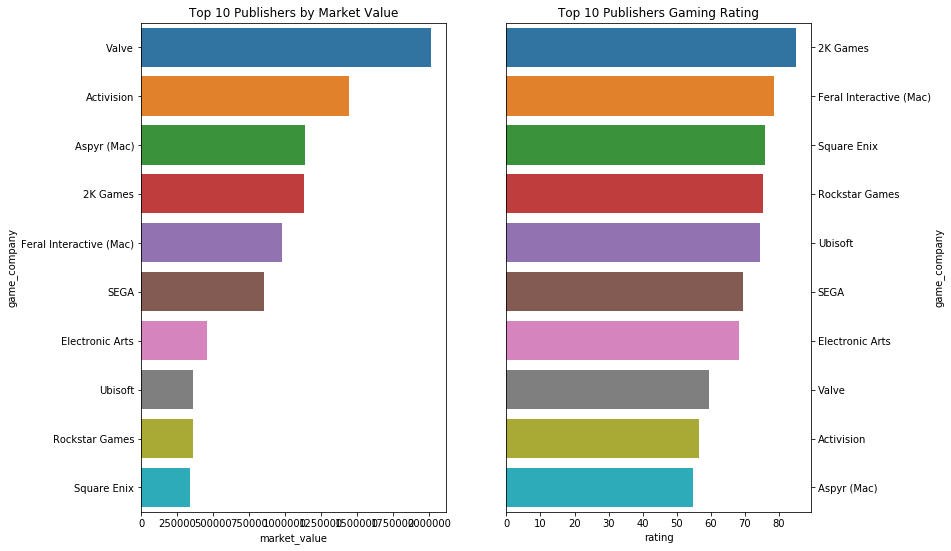

In [335]:
### Who is the market's most dominant compan in terms of market value ( number of games x avg.game price)? 
### What are their games' rating like?
publisher = df.groupby('Publisher').agg({'Title':'count','Price':'mean'}).sort_values(by='Title',ascending=False).head(10)
publisher_market= pd.DataFrame({'game_company':publisher.index,'market_value':publisher.Title.values * publisher.Price.values})
publisher_market= publisher_market.sort_values(by='market_value',ascending=False)
mask = df.Publisher.isin(publisher.index)
rating = df[mask].groupby('Publisher').mean()['Rating'].sort_values(ascending=False)
rating = pd.DataFrame({'game_company':rating.index,'rating':rating.values})
f,ax=plt.subplots(1,2,figsize=(12,9))
sns.barplot(y='game_company',x='market_value',data=publisher_market,ax=ax[0]).set(title='Top 10 Publishers by Market Value')
sns.barplot(y='game_company',x='rating',data=rating,ax=ax[1]).set(title='Top 10 Publishers Gaming Rating')
ax[1].yaxis.tick_right()
ax[1].yaxis.set_label_position('right')

- The game publishers with the most market value were Valve, Activision and Aspyr(Mac). When looking at their game qualities, they only ranked at the last three positions at the corresponding rating list. Publishers value quality the most ranked 4th and 5th position in the market, which could imply current market is mainly driven by cost leadership and mass consumption.High quality games tailored to specific audience segment who truly values optimal gaming experience. 

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), <a list of 10 Text xticklabel objects>)

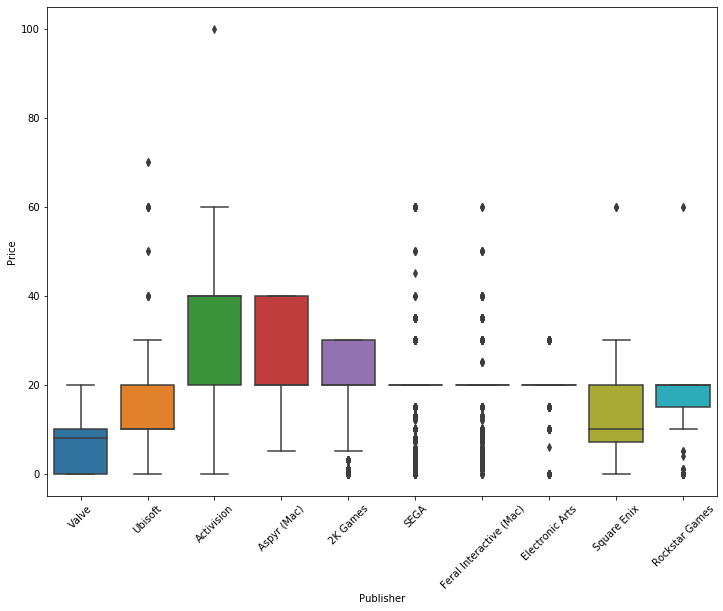

In [347]:
## What were their pricing strategy like?
price = df.loc[mask][['Publisher','Price']]
f,ax=plt.subplots(figsize=(12,9))
sns.boxplot(x='Publisher',y='Price',data=price)
plt.xticks(rotation=45)

- Not surprisingly, Valve is clearly driven by cost leadership. Activision, 2K Games and Aspyr are all within the lower middle price range. However, their gaming experience didn't justify their higher price than Valve, which resulted in their low game rating. 2K Games really stood out considering its affordable market price and premium games rating as a clear example of affordable product differentiation, however they also underestimate their pricing power by charging much less than competitors at the same price range.For 2K Games, they should upscale their marketing campaigns and implement cross-selling / up-selling to increase avg. selling price. Feral Interactive and SEGA's steep prices are potentially the hurdle for their mass market penetration. 

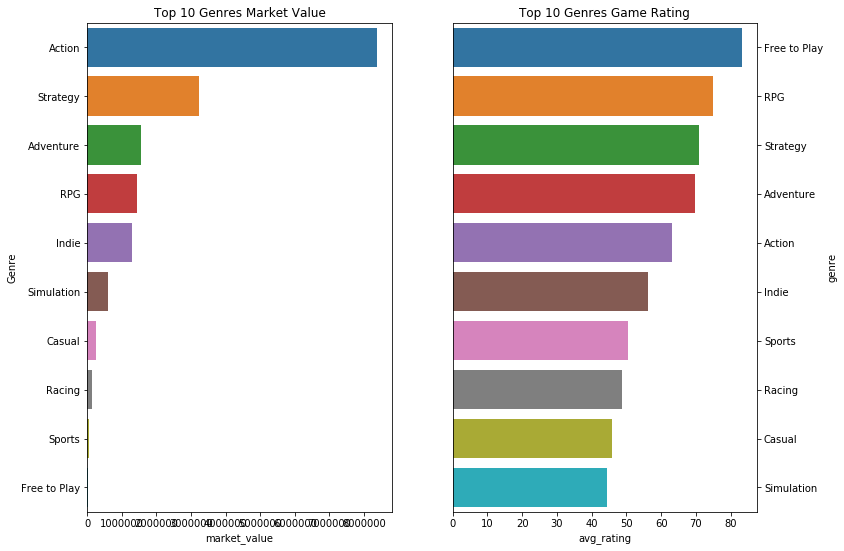

In [367]:
### What are the most profitable game Genre and their corresponding rating?
genre= df.groupby('Genre').agg({'steamid':'count','Price':'mean','Rating':'mean'}).sort_values(by='steamid',ascending=False).head(10)
mask = df.Genre.isin(genre.index)
genre_market_value =pd.DataFrame({'Genre':genre.index,'market_value':genre.Price.values * genre.steamid.values,'rating':genre.Rating.values})
genre_market_value= genre_market_value.sort_values(by='market_value',ascending=False)
rating =df.loc[mask].groupby('Genre').mean()['Rating'].sort_values(ascending=False)
rating= pd.DataFrame({'genre':rating.index,'avg_rating':rating.values})
f,ax = plt.subplots(1,2,figsize=(12,9))
sns.barplot(y='Genre',x='market_value',data=genre_market_value,ax=ax[0]).set(title='Top 10 Genres Market Value')
sns.barplot(y='genre',x='avg_rating',data=rating,ax=ax[1]).set(title='Top 10 Genres Game Rating')
ax[1].yaxis.tick_right()
ax[1].yaxis.set_label_position('right')

- The most profitable genres are Action and Strategy. Free to Play, RPG and Strategy have the highest game ratings. 

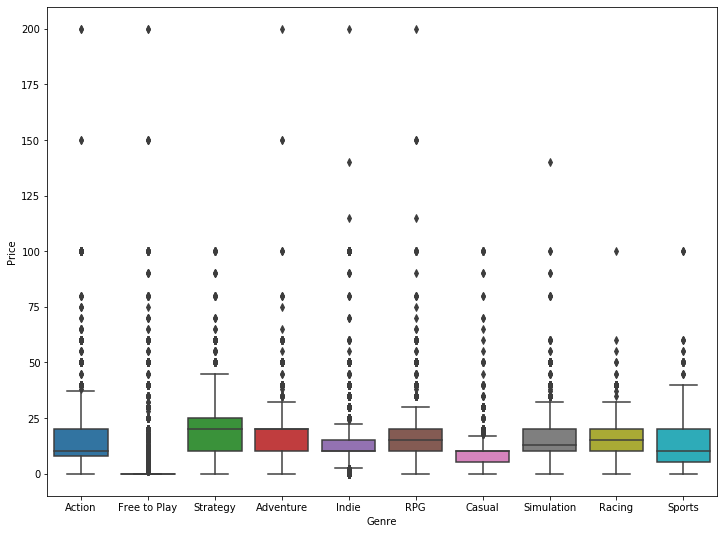

In [379]:
price = df.loc[mask][['Genre','Price']]
f,ax=plt.subplots(figsize=(12,9))
sns.boxplot(x='Genre',y='Price',data=price)

- All genre's games have similar price strategy, however, they also have extreme high priced games.  

## Game and Users Analysis
### Summary
- Most users played cheap games (Price <19.99) and they are very sensitive to price. There is a clear diversion between casual gamers and serious gamers. For casual gamers, they play quick games on game with low rating (Rating<2).When games are extremely good ( Rating=3),they will engage and play long hours. For serious gamers,they have strong preference for games with Rating >=2 and they play long hours. Companies should segment their strategy based on clear user segment bewteen serious and casual gamers in terms of price, rating and game playing time.
- Interesting observation,when looking at Price=1, players tend to play long game, could be becasue they invest the money and they feel more incentivised to make the most of it.Companies could use paid games as a way to increase game engagement among users. 
- According to the plots, most played games are not highest rated. The most played games are Dota 2, followed by Call of Duty 2 and Civilization V. When looking at most played games for most active gamers, we observed that there is a clear game preference diversion between serious gamers and mass market /casual gamers, hence for companies they should segment their campaigns & strategy tailoring to different audience group of casual vs serious gamers. Civilization V was the only exception that was both commercially successful for both casual and serious gamers. 
- Acrroding to data, only 8% of steam players are serious gamers with playing time more than 216 hours. Average gamers spend 84 hrs on games.  
- The most played games tend to have extreme playing time. Those games have the characteristic of multiplayer,no age restriction and excessive / addictive playing behaviour.For those games, we need to have resoponsible playing policies in place and set playing time limit to address any gaming addiction.  
- The pricing strategy for most played games could help generalize the price affordability without compromising games' popularity,ranging from $20 - $40. Current maket is congested with cut-throat competiton in the lower price market. There is huge market potential for upper middle price range gaming products. 

### Qunatitile Bands for  Price, Rating, game2_playtime_forever, Percentage
- We cut Price, Rating, game2_playtime_forever, Percentage to quantitle bands and turn them to cardinal values 
- Price <=19.99,Price=0, otherwise Price =1
- Rating<=65,Rating=0; (65,81] Rating = 1 ;  (81,88] Rating=3;  >88, Rating=3
- playtime<9, playtime = 0; (9,411] playtime = 1; >411, playtime=2
- Percentage<=15.603, Percentage= 0, 
otherwise 1

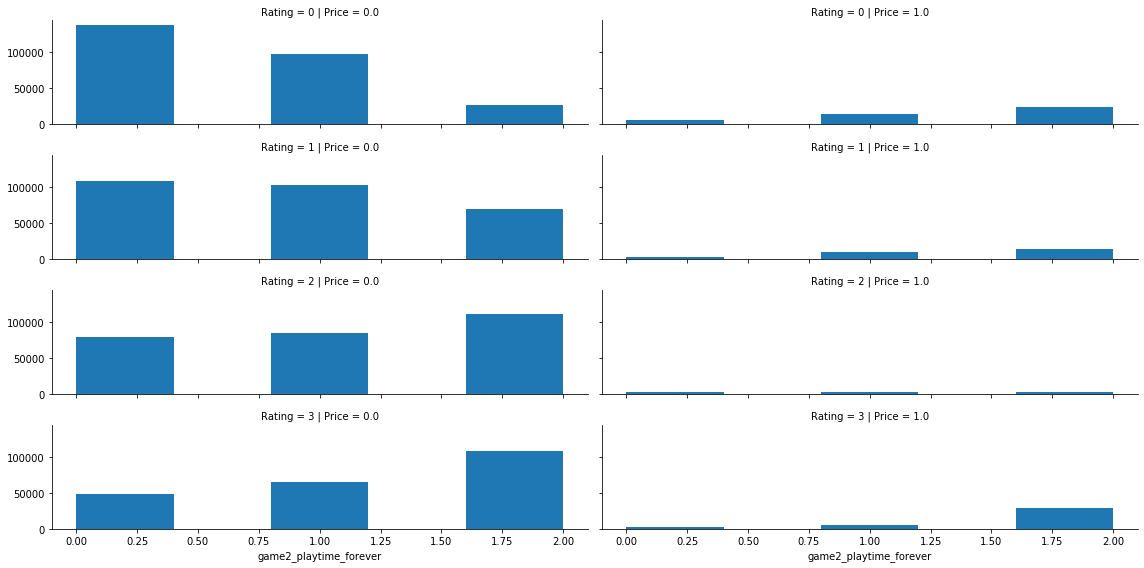

In [42]:
g=sns.FacetGrid(df_new,col='Price',row='Rating',size=2,aspect=4)
g.map(plt.hist,'game2_playtime_forever',bins=5)

- As graphs showed, most people played cheap games (Price =0 when Price <19.99),price still greatly determines whether users play the games or not
- When the game has low rating(Rating <2), they only played very quick games without further engagement. When the games have high rating( Rating >=2), the players' behaviour instantly shifted, they played long games ( more than 411 minutes)
- When looking at price=1, players tend to play long games, could be becasue they invest the money and they feel more incentivised to make the most of it. 

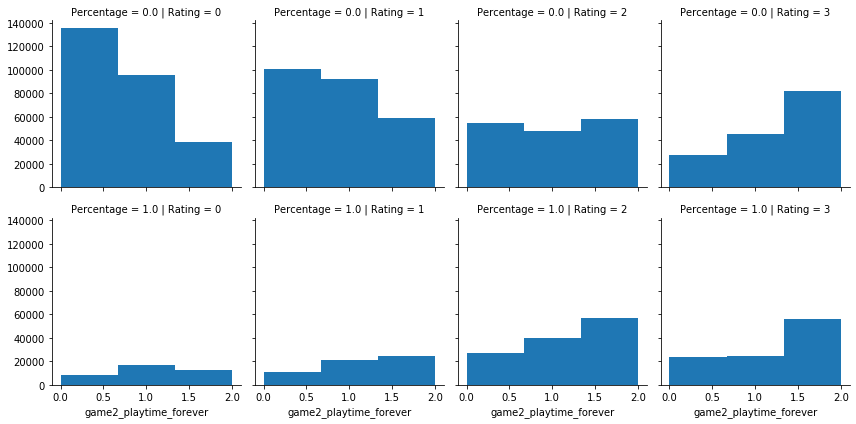

In [39]:
g=sns.FacetGrid(df_new,col='Rating',row='Percentage')
g.map(plt.hist,'game2_playtime_forever',bins=3)

- Users who are more causal player( Percentage=0),they play more on games with Rating <2, when games are extremely good ( Rating=3),they will engage and play long hours
- Users who are more serious player(Percentage =1),they have strong preference for games with Rating >=2 and they play long hours
- Clear game preference diversion between casual and serious gamers

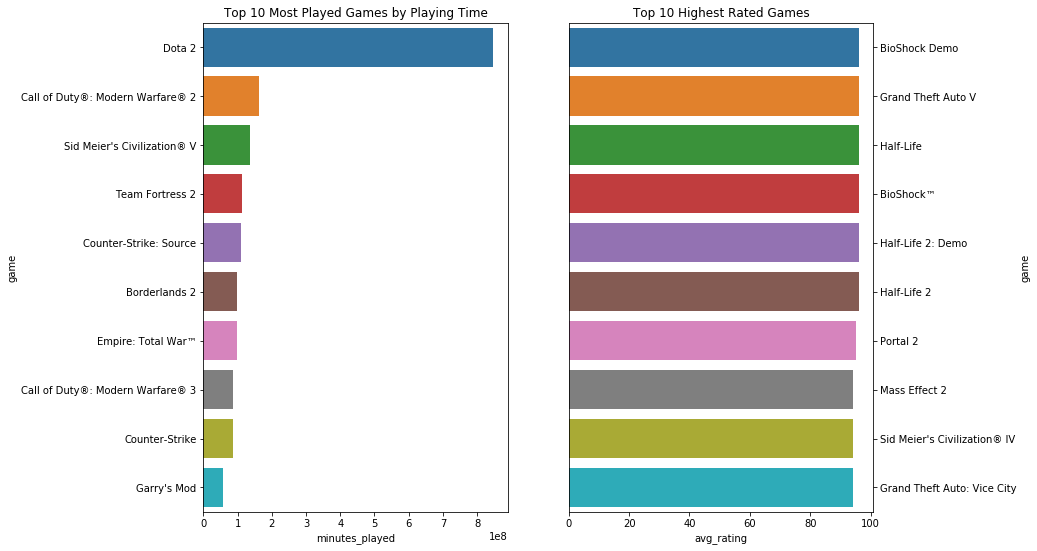

In [319]:
# What are the most played games, do they have the highest ratings?
minutes_played=df.groupby(['Title']).sum().sort_values(by=['game2_playtime_forever'],ascending=False)['game2_playtime_forever']
minutes_played=pd.DataFrame({'game':minutes_played.index,'minutes_played':minutes_played.values})[:10]
avg_rating=df.groupby(['Title']).mean().sort_values(by='Rating',ascending=False)['Rating']
rating = pd.DataFrame({'game':avg_rating.index,'avg_rating':avg_rating.values})[:10]
fig,ax=plt.subplots(1,2,figsize=(12,9))
sns.barplot(y='game',x='minutes_played',data=minutes_played,ax=ax[0]).set(title='Top 10 Most Played Games by Playing Time')
sns.barplot(y='game',x='avg_rating',data=rating,ax=ax[1]).set(title='Top 10 Highest Rated Games')
ax[1].yaxis.tick_right()
ax[1].yaxis.set_label_position('right')

- According to the plots, most played games are not highest rated. The most played games are Dota 2, followed by Call of Duty 2 and Civilization V.

[Text(0.5, 1.0, 'Top Games Played by Most Active Users')]

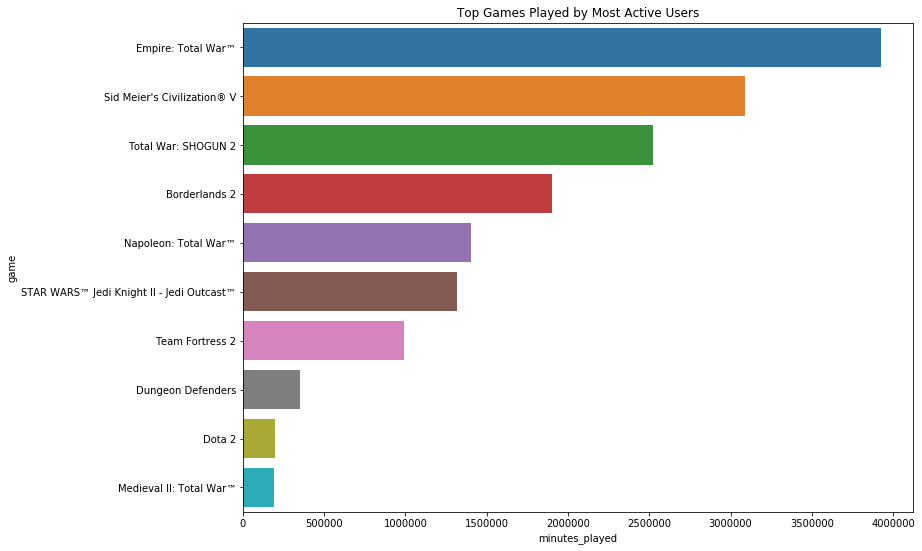

In [87]:
### Look at the most active steam players by minutes played and have a glance at the games they played
user_minutes= df.groupby('steamid').sum()['game2_playtime_forever'].sort_values(ascending=False).head(10)
mask =df.steamid.isin(user_minutes.index)
minutes_played = df.loc[mask].groupby('Title')['game2_playtime_forever'].sum().sort_values(ascending=False)
minutes_played = pd.DataFrame({'game':minutes_played.index,'minutes_played':minutes_played.values})[:10]
f,ax=plt.subplots(1,figsize=(12,9))
sns.barplot(y='game',x='minutes_played',data=minutes_played).set(title='Top Games Played by mos')



- When looking at most played games for most active gamers, we observed some very interesting foundings. 
For most active steam users, Civilization V and Empire: Total War were the most played games whereas only on the 3rd and 7th position of the most_played games.The main stream most popular games such as Dota2 only ranked 9th in the top 10 list.Hence,there is a clear game preference diversion between serious gamers and mass market /casual gamers, for companies they should segment their campaigns & strategy tailoring to different audience group of casual vs serious gamers.

In [69]:
## Find out serious gamers in terms of playing time, which is mean + 1 Std.Deviation 
df_grouped['Serious_Gamer']=df_grouped.game2_playtime_forever>13000 ### 13000 being mean + 1 Std.Deviation
print(df_grouped.Serious_Gamer.sum(),'out of ',df_grouped.Serious_Gamer.count(),'steam players are serious gamers with playing time more than 13000 minutes')

4726 out of  58809 steam players are serious gamers with playing time more than 13000 minutes


[Text(0.5, 1.0, 'Avg.Price for Top 20 Most Played Games')]

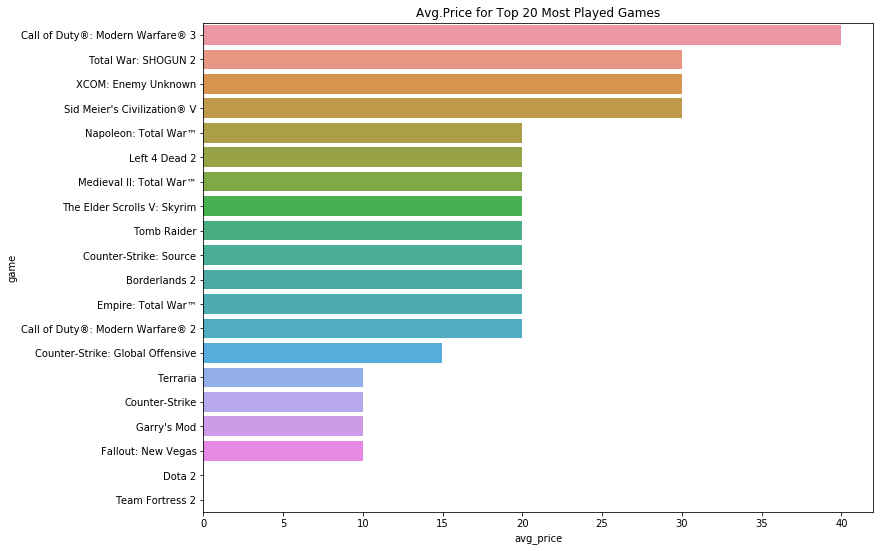

In [88]:
### Check product price for top 20 most played games to help understand pricing strategy,market potential and current competition
most_played =df.groupby('Title').sum()['game2_playtime_forever'].sort_values(ascending=False).head(20)
mask= df.Title.isin(most_played.index)
avg_price=df.loc[mask].groupby('Title').mean()['Price'].sort_values(ascending=False)
avg_price=pd.DataFrame({'game':avg_price.index,'avg_price':avg_price.values})
f,ax=plt.subplots(figsize=(12,9))
sns.barplot(y='game',x='avg_price',data=avg_price).set(title='Avg.Price for Top 20 Most Played Games')

[Text(0.5, 1.0, 'Price Scatterplot by Publisher')]

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0, flags=flags)


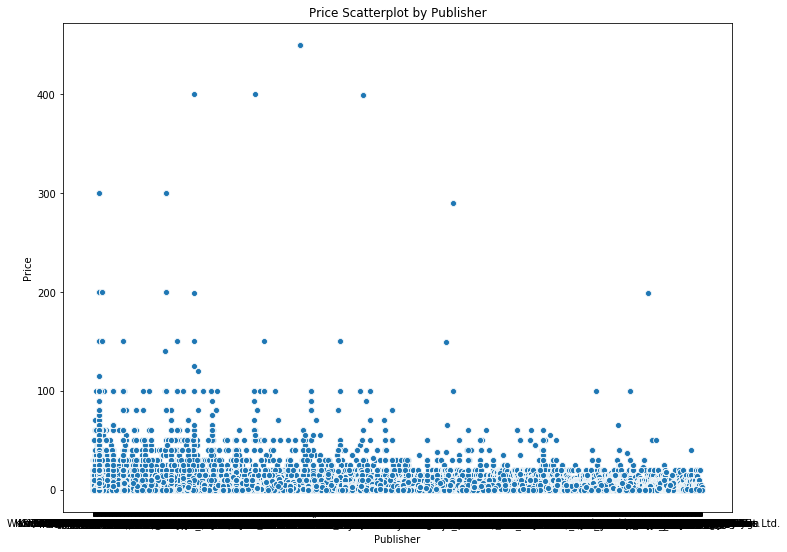

In [90]:
### Game Price Scatterplot
f,ax=plt.subplots(figsize=(12,9))
sns.scatterplot(x='Publisher',y='Price',data=df).set(title='Price Scatterplot by Publisher')

- According to the most played games avg price,all the games sit within the lower middle range of price corridor with Dota 2 being a free game.According to overall price scatterplot,majority points lied between 0 and 50, it was right skewd with high price outliers.This could help to generalize the price affordability without compromising games' popularity,ranging from $20 - $40.There is also huge market potential for upper middle price range with much less competition.

[None]

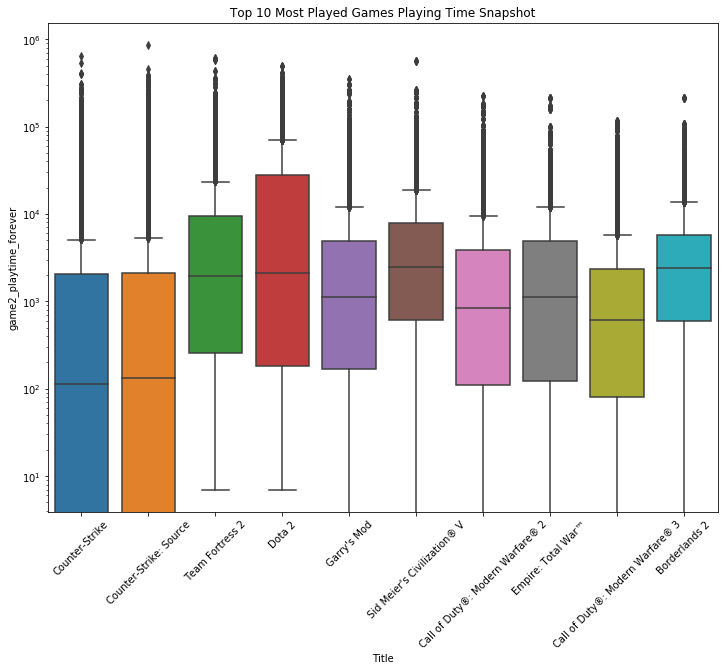

In [89]:
### We want to explore more of most played games in terms of playing time and see how it distributed
most_played =df.groupby('Title').sum()['game2_playtime_forever'].sort_values(ascending=False).head(10)
mask=df.Title.isin(most_played.index)
most_played_mins=df.loc[mask][['Title','game2_playtime_forever']]
f,ax=plt.subplots(figsize=(12,9))
sns.boxplot(y='game2_playtime_forever',x='Title',data=most_played_mins).set(title='Top 10 Most Played Games Playing Time Snapshot')
plt.xticks(rotation=45)
ax.set(yscale='log')

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], <a list of 10 Text xticklabel objects>)

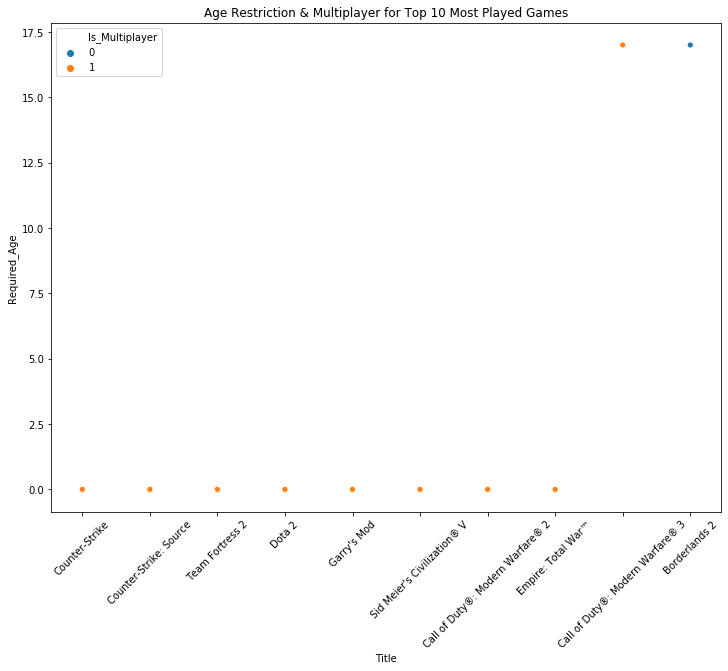

In [91]:
### For most played games, we want to explore what does their Required_Age and Is_Multiplayer look like?
game_age = df.loc[mask][['Title','Required_Age','Is_Multiplayer']]
f,ax=plt.subplots(figsize=(12,9))
sns.scatterplot(game_age.Title,game_age.Required_Age,hue=game_age.Is_Multiplayer).set(title='Age Restriction & Multiplayer for Top 10 Most Played Games')
plt.xticks(rotation=45)

- As we can see from boxplot, Dota 2 had the most playing times and there are some users tend to have very extreme and widely spread out playing times,especially for Counter Strike: Source and Team Fortress 2.According to 2nd graph,those games are multiplayed and majority don't have age restriction. Obsessive playing behavious could be a problem, especially for young people.  

### User Profiling
#### Summary
- According to LogisticRegression model, as Percentage & Rating increase, the probability of users being serious gamers increases the most. 
- According to KMeans Clustering, we can clearly cluster users into different groups based on number of games played and avg. rating of games played (we could see clear game rating threshold). This could help differentiate serious gamers and casual gamers, as well as marketing campaigns / pricing strategy to tailor to customers based on their game quality requirements. 

### Logistic Regression

In [126]:
## Based on created new columns 'Serious'( whether the player is serious player) as y_train, we use LogisticRegression to understand feature importance 
logreg=LogisticRegression()
logreg.fit(X_train,y_train)
coefs= pd.Series(logreg.coef_[0],index=X_train.columns)
img=pd.DataFrame([coefs.sort_values().head(4),coefs.sort_values().tail(4)])

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


[Text(0.5, 1.0, 'Feature Importance')]

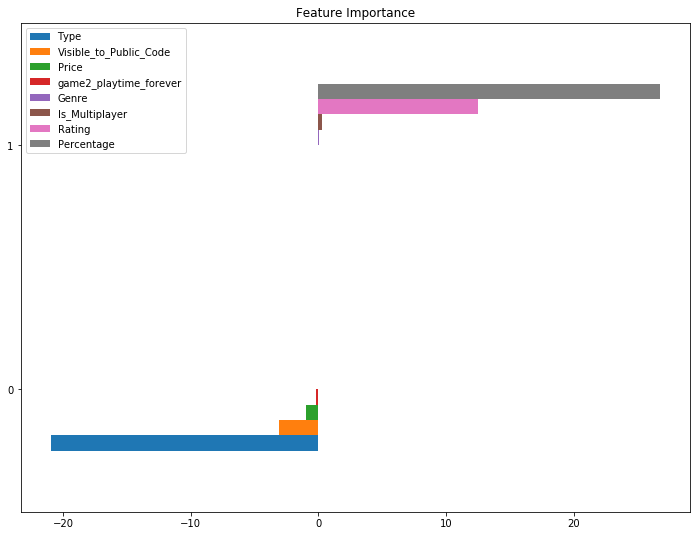

In [127]:
img.plot(kind='barh',figsize=(12, 9)).set(title='Feature Importance')

- Percentage is highest positive coef,implying as Percentage increases, the probability of Serious =1 increases the most. Rating is the 2nd highest positive coef and as Rating increases, the probability of Serious =1 increases.
- Inversely, as Type increases, the probability of Serious =1 decreases the most, which implies most serious gamers only play game as type. 

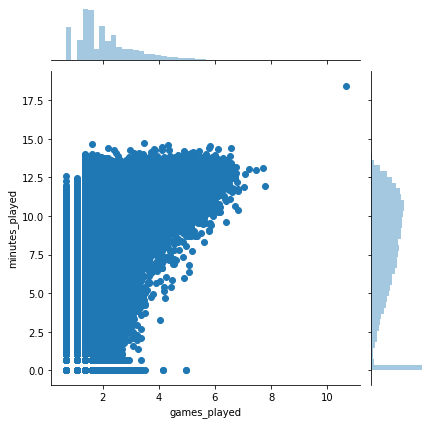

In [98]:
### we will try to cluster users to determine user profile.
## To do this, we will use: number of games, number of hours played per user,game completion percentage per user
##I did log transformation to help finding patterns.  
minutes_played =df.groupby('steamid').sum()['game2_playtime_forever'].sort_values(ascending=False)
users_num = df.groupby('steamid').count()['Type'].sort_values(ascending=False)
users_num=pd.DataFrame({'steamid':users_num.index,'games_played':users_num.values})
minutes_played = pd.DataFrame({'steamid':minutes_played.index,'minutes_played':minutes_played.values})
data = minutes_played.merge(users_num,left_on='steamid',right_on='steamid',how='left')
data.games_played=np.log1p(data.games_played)
data.minutes_played=np.log1p(data.minutes_played)
sns.jointplot(x= data.games_played,y =data.minutes_played)

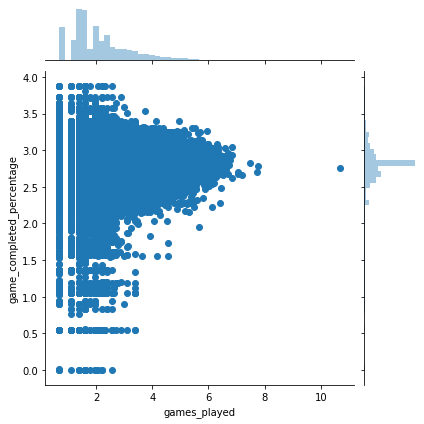

In [94]:
### Create df for game completion percentage per user 
percentage= df.groupby('steamid').mean()['Percentage'].sort_values(ascending=False)
percentage=pd.DataFrame({'steamid':percentage.index,'game_completed_percentage':percentage.values})
data_1= users_num.merge(percentage,left_on='steamid',right_on='steamid',how='left')
data_1.game_completed_percentage=np.log1p(data_1.game_completed_percentage)

sns.jointplot(x=data.games_played,y=data_1.game_completed_percentage)

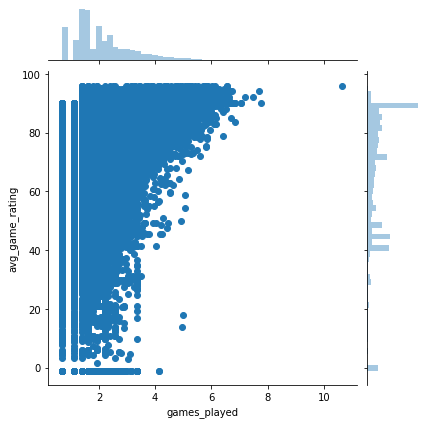

In [95]:
## Create df for avg. rating for games per user played
rating= df.groupby('steamid').mean()['Rating'].sort_values(ascending=False)
rating=pd.DataFrame({'steamid':rating.index,'avg_game_rating':rating.values})
data_2= users_num.merge(rating,left_on='steamid',right_on='steamid',how='left')

sns.jointplot(x=data.games_played,y=rating.avg_game_rating)

[Text(0.5, 1, 'User Profiling Heatmap')]

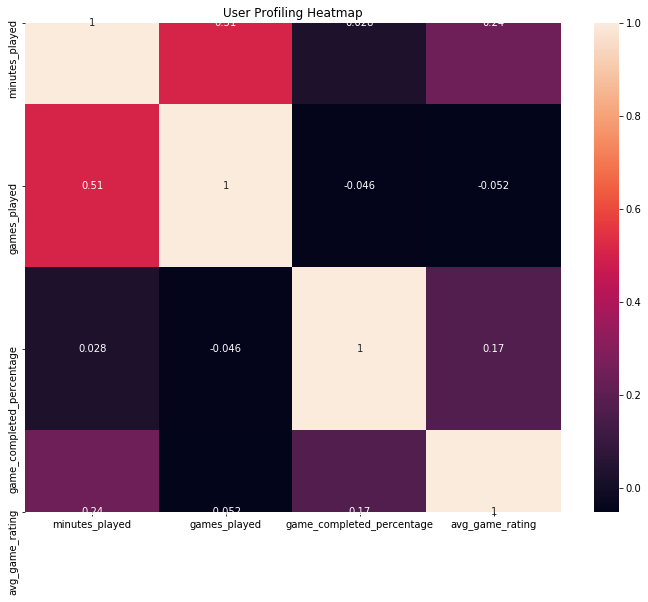

In [96]:
## Logically, there is a positive correlation between number of games played and game playing time.
## There is very small positive correlation between avg.game rating and game compeltion rate per user. 
## However,game completion percenatge doesn't have effect on number of games played or game playing time.
data = data.merge(percentage,left_on='steamid',right_on='steamid',how='left')
data = data.merge(rating,left_on='steamid',right_on='steamid',how='left')
temp = data.copy()
del temp['steamid']
f,ax=plt.subplots(figsize=(12,9))
sns.heatmap(temp.corr(),annot=True).set(title='User Profiling Heatmap')

- According to graphs in User Profiling, as number of games played increases,playing time increases. However, up until a number of games, users's playing time stabilised and won't increase any more. For avg. game completion rate, as game number increases, users with higher completion rate and users with lower completion rate converged to a middle point which alsp happens to be the mean completion rate. For avg.game rating, there is a clear tiered benchmark for minimum games ratings. As number of games played increases,rating is weighted much more in user's game choices. 
- There is very small positive correlation between avg.game rating and game completion rate per user. However,game completion percentage doesn't have an effect on number of games played or game playing time.

### K Means

In [276]:
## Use df based on User Profiling to fit KMeans model 
df_grouped_k = df.groupby(['steamid']).mean()[['Price','Rating','Percentage','game2_playtime_forever','n_friends']]
users_num = df.groupby('steamid').count()['Type'].sort_values(ascending=False)
users_num=pd.DataFrame({'steamid':users_num.index,'games_played':users_num.values})
df_grouped_k= pd.DataFrame({'steamid':df_grouped_k.index,'Price':df_grouped_k.Price.values,'Rating':df_grouped_k.Rating.values,
             'Game_Completion_Percentage':df_grouped_k.Percentage.values,'minutes_played':df_grouped_k.game2_playtime_forever.values,
             'n_friends':df_grouped_k.n_friends.values})
df_grouped_k=users_num.merge(df_grouped_k,left_on='steamid',right_on='steamid',how='left')

temp = df_grouped_k.copy()
del temp['steamid']
train_data = temp.values

## Scaling of train_data and fit to KMeans model with n_clusters =8
scaler= StandardScaler()
data_scaled = scaler.fit_transform(train_data)
km = KMeans(n_clusters=8)
km.fit(data_scaled)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=8, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

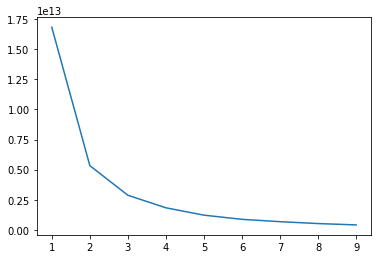

In [277]:
## Elbow Curve to determine the optimal cluster number. 
##According to the graph, the optimal number we can choose between 3 and 6 
error =[]
for i in range(1,10):
    km= KMeans(n_clusters=i)
    km.fit(train_data)
    error.append(km.inertia_)
plt.plot(range(1,10),error)

In [280]:
## Choose n_clusters =4 and create output df to display clustering result
km=KMeans(n_clusters=4)
km.fit(data_scaled)
y_pred= km.predict(data_scaled)
labels = km.labels_
label_color_map={0:'pink',1:'blue',2:'green',3:'yellow'}
label_color=[label_color_map[i] for i in labels]
output = pd.DataFrame(data_scaled)
output['cluster']=y_pred
output.cluster.value_counts()

0    34301
2    21640
1     2867
3        1
Name: cluster, dtype: int64

Text(0.5, 1.0, 'K means: Games Played vs Game Price with X, Y log scale')

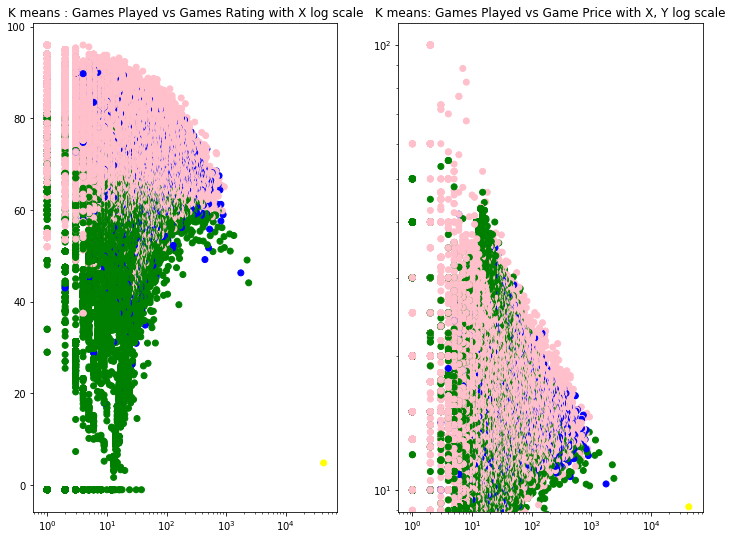

In [281]:
f,ax=plt.subplots(1,2,figsize=(12,9))
ax[0].scatter(x=temp[['games_played']],y=temp[['Rating']],c=label_color)
ax[0].set_xscale('log')
# ax[0].set_yscale('log')

ax[0].set_title('K means : Games Played vs Games Rating with X log scale')
ax[1].scatter(x=temp[['games_played']],y=temp[['Price']],c=label_color)
ax[1].set_xscale('log')
ax[1].set_yscale('log')
ax[1].set_title('K means: Games Played vs Game Price with X, Y log scale' )

- According to KMeans Clustering, we can clearly cluster users into different groups based on number of games played and avg. rating of games played, this aligns with previous assumption of differetiating serious gamers and casual gamers and we could see clear game rating threshold. However, it is difficult to identify any patterns based on other attributes. 

## Executive Summary

### Summary
- Current market has 3 clear segments: cost leadership (Valve), middle price market with product differentiation (2K Games,Activision and Aspyr) and upper price market with more niche audience (Feral Interactive and SEGA).Cut-throat competition in the lower price range market and white Space market for middle to premium price range games with much less competition though higher entry barrier ( more demanding game quality technology requirement)
- The pricing strategy adopted by current market ranges from 20 to 40 where users achieve affordability and minimum game quality. 
- In terms of game genre, the most profitable genres are Action and Strategy. RPG and Strategy games are also highest rated.
- There is a clear gaming user diversion between casual and serious gamers. Casual gamers are sensitive to price (Price <19.99) and play quick games and only engage when games are highest rated. For serious gamers,they have strong preference for excellent rated games and they play long hours. For both types of users,they all tend to play long hours when they paid for the games.  
- Currently, the most played games are Dota 2, followed by Call of Duty 2 and Civilization V. There is a clear game preference diversion between serious gamers and mass market /casual gamers. Civilization V was the only exception that was both commercially successful for both casual and serious gamers. 
- Only 8% of steam players are serious gamers with playing time more than 216 hours. Average gamers spend 84 hrs on games.  
- The most played games have the characteristic of multiplayer,no age restriction and excessive / addictive playing behaviour. 
- Current game users can be clustered into different groups based on number of games played and avg. rating of games played with a clear game rating threshold. Meanwhile,as Percentage & Rating increase, the probability of users being serious gamers increases the most.

### Action Plan
- Strategy:
  
  (1)Company sit within middle price corridor with premium game ratings should use cross-selling/ up-selling/ add-ons to increase their avg.game price to match their superior game qualities and acquire more users through more aggresive marketing campaigns.   
  (2)Company sit within middle price range with low game ratings should either drop price / improve game quality to acquire more users.     
  (3)Company with premium price range should focus on continuoulsy improving game quality to justify their premium price.  
  (4) All companies should focus on developing are Action, Strategy and RPG games. 
  
  (5) There is white space market for middle to premium price range market with less competiton and company should consider tap into it especially for serious gamers customer segment.  

- Game & Users: 
  
  (1) Companies should segment their campaigns & strategy tailoring to different audience group of casual vs serious gamers. 
  
  (2) Companies could use paid games as incentives to encourage game engagement for less active games. 
  
  (3) For games with extreme playing time (most played games etc.), companies need to have resoponsible playing policies in place and set playing time limit to address any gaming addiction.
  
  (4) Companies could use users segmentation based on number of games played and avg.rating of games played to help differentiate serious gamers and casual gamers, as well as marketing campaigns / pricing strategy to tailor to customers based on their game quality requirements. 